In [19]:
import cv2
import gluoncv
import gym
import numpy as np
from gym import spaces
import copy
from matplotlib import pyplot as plt

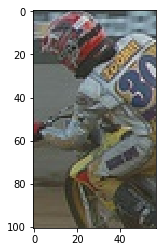

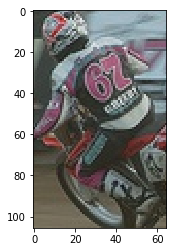

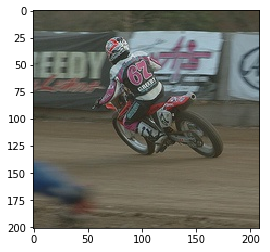

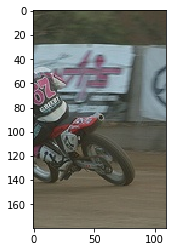

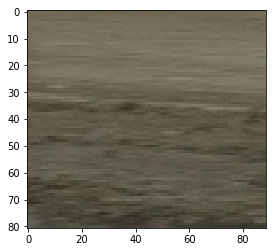

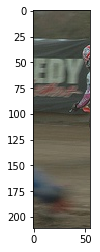

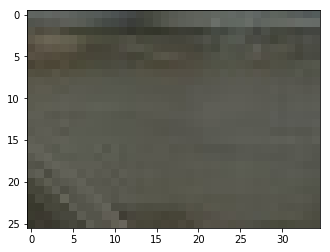

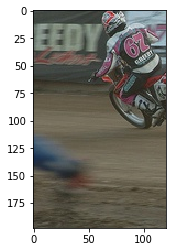

In [43]:
## FROM GYM-PROJECT

class BoundingBox:
    def __init__(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2

    def area(self):
        if self.x2 < self.x1 or self.y2 < self.y1:
            return 0
        return (self.x2 - self.x1) * (self.y2 - self.y1)

    def __repr__(self):
        return f"(x1,y1)=({self.x1}, {self.y1}), (x2,y2)=({self.x2}, {self.y2})"


def intersection_over_union(bb1, bb2):
    intersection_bb = BoundingBox(x1=max(bb1.x1, bb2.x1),
                                  y1=max(bb1.y1, bb2.y1),
                                  x2=min(bb1.x2, bb2.x2),
                                  y2=min(bb1.y2, bb2.y2))
    iou = intersection_bb.area() / (bb1.area() + bb2.area() - intersection_bb.area())
    if iou > 1:
        print("FAULTY IOU", iou)
        print("bb1", bb1)
        print("bb2", bb2)
        print("intersection_bb", intersection_bb)
    return iou


def get_indexes_class(root, voc_dataset, detected_class, set_name="trainval"):
    fname = f"{root}/VOC2007/ImageSets/Main/{voc_dataset.classes[detected_class]}_{set_name}.txt"
    with open(fname) as f:
        content = f.readlines()

    content_index = [int(x.strip().split()[0]) for x in content]
    content_detected_class = [int(x.strip().split()[0]) for x in content if int(x.strip().split()[1]) == 1]
    content_detected_class_filtered = []
    i = 0
    for class_img_index in content_detected_class:
        while True:
            if content_index[i] == class_img_index and i < len(content_index):
                content_detected_class_filtered.append(i)
                break
            i += 1
    return content_detected_class_filtered


def filter_labels(labels):
    return labels[labels[:, 4] == detected_class]


def get_labels_bb(labels):
    bbs = []
    for i in range(labels.shape[0]):
        bbs.append(BoundingBox(int(labels[i, 0]), int(labels[i, 1]), int(labels[i, 2]), int(labels[i, 3])))
    return bbs
    
def get_patches(voc_dataset, img_index):
    image, label = voc_dataset[img_index]
    filtered_label = filter_labels(label)
    bbs = get_labels_bb(filtered_label)
    patches = [image[bb.y1:bb.y2, bb.x1:bb.x2].asnumpy() for bb in bbs]
    return patches, bbs

def get_hard_negatives(voc_dataset, img_index):
    image, label = voc_dataset[img_index]
    threshold = 0.3
    # we choose to do 1 positive : 3 negative
    nb_negative_for_each_positive = 3
    positives, positives_bb = get_patches(voc_dataset, img_index)
    
    negatives = []
    negatives_bbs = []
    i=0
    while i < nb_negative_for_each_positive * len(positives):
        randoms = (np.random.rand(4) * min(image.shape[0], image.shape[1])).astype(int)
        x1 = int(min(randoms[0], randoms[1]))
        x2 = int(max(randoms[0], randoms[1]))
        y1 = int(min(randoms[2], randoms[3]))
        y2 = int(max(randoms[2], randoms[3]))
        bb = BoundingBox(x1,y1, x2, y2)
        valid = True
        for positive_bb in positives_bb:
            iou = intersection_over_union(bb, positive_bb)
            if iou > threshold:
                valid = False
                break
        if valid:
            negatives.append(image[bb.y1:bb.y2, bb.x1:bb.x2].asnumpy())
            negatives_bbs.append(bb)
            i += 1
    return negatives, negatives_bbs


def resize_img(img, output_image_size=224):
    return cv2.resize(img, (output_image_size,output_image_size))
detected_class = 14
root="/home/jg/MILA/COMP767-Reinforcement_Learning/COMP767/project/data/VOCtrainval_06-Nov-2007/VOCdevkit"
voc_dataset = gluoncv.data.VOCDetection(root=root, splits=[(2007, "trainval")])

indexes = get_indexes_class(root, voc_dataset, detected_class)


index = indexes[102]
patches, bbs = get_patches(voc_dataset, index)
# print(patches)
for patch in patches : 
    plt.imshow(patch)
    plt.show()
    
negatives, n_bbs = get_hard_negatives(voc_dataset, index)
for negative in negatives : 
    plt.imshow(negative)
    plt.show()

In [44]:
positives = []
hard_negatives = []
for index in indexes:
    patches, bbs = get_patches(voc_dataset, index)    
    negatives, n_bbs = get_hard_negatives(voc_dataset, index)
    
    positives.extend([resize_img(patch) for patch in patches])
    hard_negatives.extend([resize_img(patch) for patch in negatives])

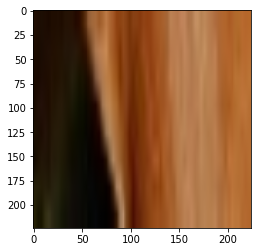